# LLaDA Diffusion Process Inspection & Experimentation

이 노트북은 LLaDA 모델의 디퓨전 기반 텍스트 생성 과정을 단계별로 분석하고, **새로운 샘플링 알고리즘을 실험하여 베이스라인과 비교**하기 위해 작성되었습니다.

## 주요 기능
1. **Inspection**: 디퓨전 과정의 투명한 시각화 (Step-by-step Logits, Confidence).
2. **Experimentation**: 커스텀 샘플링 알고리즘 구현 및 적용.
3. **Comparison**: Baseline vs Custom 알고리즘의 성능(NFE, 속도, 품질) 정량 비교.

In [1]:
import os
import platform
import psutil
import torch
import shutil
import subprocess


print("===== BASIC SYSTEM INFO =====")
print(f"OS            : {platform.system()} {platform.release()}")
print(f"Python        : {platform.python_version()}")
print(f"CPU           : {platform.processor()}")
print(f"CPU Cores     : {psutil.cpu_count(logical=True)}")

print("\n===== RAM INFO =====")
ram = psutil.virtual_memory()
print(f"Total RAM     : {ram.total / (1024**3):.2f} GB")
print(f"Available RAM : {ram.available / (1024**3):.2f} GB")
print(f"Used RAM      : {ram.used / (1024**3):.2f} GB")
print(f"RAM Usage     : {ram.percent} %")

print("\n===== DISK INFO =====")
disk = shutil.disk_usage("/")
print(f"Total Disk    : {disk.total / (1024**3):.2f} GB")
print(f"Used Disk     : {disk.used / (1024**3):.2f} GB")
print(f"Free Disk     : {disk.free / (1024**3):.2f} GB")

print("\n===== GPU / CUDA INFO =====")
print(f"CUDA Available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA Version  : {torch.version.cuda}")
    print(f"GPU Count     : {torch.cuda.device_count()}")

    for i in range(torch.cuda.device_count()):
        props = torch.cuda.get_device_properties(i)
        total_vram = props.total_memory / (1024**3)
        allocated = torch.cuda.memory_allocated(i) / (1024**3)
        reserved = torch.cuda.memory_reserved(i) / (1024**3)

        print(f"\n[GPU {i}]")
        print(f"Name          : {props.name}")
        print(f"Total VRAM    : {total_vram:.2f} GB")
        print(f"Allocated VRAM: {allocated:.2f} GB")
        print(f"Reserved VRAM : {reserved:.2f} GB")
else:
    print("GPU not detected")

print("\n===== NVIDIA-SMI (if available) =====")
try:
    smi = subprocess.check_output(["nvidia-smi"], encoding="utf-8")
    print(smi)
except Exception as e:
    print("nvidia-smi not available")

===== BASIC SYSTEM INFO =====
OS            : Linux 5.15.0-78-generic
Python        : 3.12.12
CPU           : x86_64
CPU Cores     : 64

===== RAM INFO =====
Total RAM     : 503.67 GB
Available RAM : 444.69 GB
Used RAM      : 58.99 GB
RAM Usage     : 11.7 %

===== DISK INFO =====
Total Disk    : 1758.86 GB
Used Disk     : 1584.85 GB
Free Disk     : 84.59 GB

===== GPU / CUDA INFO =====
CUDA Available: True
CUDA Version  : 12.8
GPU Count     : 1

[GPU 0]
Name          : NVIDIA RTX A6000
Total VRAM    : 47.43 GB
Allocated VRAM: 0.00 GB
Reserved VRAM : 0.00 GB

===== NVIDIA-SMI (if available) =====
Thu Jan 15 14:16:33 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC

In [2]:
import os
import sys
import time
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModel, AutoConfig

# 현재 노트의 디렉토리를 path에 추가
current_dir = os.getcwd()
if current_dir not in sys.path:
    sys.path.append(current_dir)

try:
    from modeling_llada import LLaDAModelLM
    from configuration_llada import LLaDAConfig
    from decoding import add_gumbel_noise, get_num_transfer_tokens
    print("Local modules loaded successfully.")
except ImportError as e:
    print(f"Critical Error: {e}")

# 시각화 설정
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]
sns.set_theme(style="whitegrid")

Local modules loaded successfully.


## 1. 모델 로드

In [3]:
# 설정: 로컬 경로가 있으면 우선 사용, 없으면 HF Hub 사용
LOCAL_MODEL_PATH = "../Grok-1-LLaDA-8B"
HF_MODEL_ID = "GSAI-ML/LLaDA-8B-Base"

model_path = HF_MODEL_ID
if os.path.exists(LOCAL_MODEL_PATH):
    model_path = LOCAL_MODEL_PATH
    print(f"Found local model at {model_path}")
else:
    print(f"Local model not found. Using HuggingFace Hub: {model_path}")

try:
    config = LLaDAConfig.from_pretrained(model_path)
    # GPU 메모리에 맞게 torch_dtype 설정 (기본: auto)
    model = LLaDAModelLM.from_pretrained(model_path, config=config, torch_dtype="auto")
    
    if torch.cuda.is_available():
        model.cuda()
    model.eval()
    
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    print("Model loaded successfully.")
except Exception as e:
    print(f"Model load failed: {e}")

Local model not found. Using HuggingFace Hub: GSAI-ML/LLaDA-8B-Base


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

Model loaded successfully.


## 2. Baseline: Standard Diffusion Sampling

가장 기본적인 LLaDA 샘플링 방식입니다.
*   **특징**: `steps`에 따라 정해진 수의 토큰을 Confidence 순으로 확정(Transfer)합니다. 한 번 확정된 토큰은 다시 바뀌지 않습니다 (No Remasking).

In [4]:
@torch.no_grad()
def baseline_sampling(model, tokenizer, prompt_text, steps=64, gen_length=64, block_length=64, temperature=0.0):
    """
    Baseline: Standard Iterative Decoding (No Remasking)
    """
    # Init
    mask_id = 126336
    if prompt_text:
        prompt_tokens = tokenizer.encode(prompt_text, return_tensors='pt').to(model.device)
    else:
        prompt_tokens = torch.tensor([[]], dtype=torch.long, device=model.device)

    B, L_prompt = prompt_tokens.shape
    x = torch.full((B, L_prompt + gen_length), mask_id, dtype=torch.long, device=model.device)
    x[:, :L_prompt] = prompt_tokens
    
    num_blocks = gen_length // block_length
    steps = steps // num_blocks
    
    history = []
    start_time = time.time()
    nfe = 0 # Number of Function Evaluations (Forward passes)

    for num_block in range(num_blocks):
        block_start = L_prompt + num_block * block_length
        block_end = L_prompt + (num_block + 1) * block_length
        
        block_mask_index = (x[:, block_start:block_end] == mask_id)
        num_transfer_tokens = get_num_transfer_tokens(block_mask_index, steps)

        for i in range(steps):
            logits = model(x).logits
            nfe += 1
            
            logits_with_noise = add_gumbel_noise(logits, temperature=temperature)
            x0 = torch.argmax(logits_with_noise, dim=-1)
            
            p = F.softmax(logits.to(torch.float64), dim=-1)
            x0_p = torch.squeeze(torch.gather(p, dim=-1, index=x0.unsqueeze(-1)), -1)
            
            mask_index = (x == mask_id)
            confidence = torch.where(mask_index, x0_p, -np.inf)
            
            if i < num_transfer_tokens.shape[1]:
                k = num_transfer_tokens[0, i].item()
            else: k = 0
            
            # Standard Transfer: Top-k confidence tokens are unmasked
            top_values, top_indices = torch.topk(confidence[0], k=k)
            transfer_mask = torch.zeros_like(x, dtype=torch.bool)
            transfer_mask[0, top_indices] = True
            x[transfer_mask] = x0[transfer_mask]
            
            # Logging
            history.append({
                'step': i, 'block': num_block, 'nfe': nfe,
                'avg_confidence': x0_p.mean().item(),
                'text': tokenizer.decode(x[0], skip_special_tokens=True)
            })

    total_time = time.time() - start_time
    return x, history, {'time': total_time, 'nfe': nfe}

## 2.5. Deep Inspection Tools

모델의 내부 동작을 상세히 분석하기 위한 도구들입니다.
- `inspect_sampling`: 각 스텝별 토큰의 변화와 확신도(Confidence)를 모두 기록합니다.
- `visualize_text_evolution`: 생성 과정을 HTML로 시각화하여 보여줍니다.
- `plot_confidence_heatmap`: 스텝별 토큰의 확신도 변화를 히트맵으로 그립니다.

In [5]:
@torch.no_grad()
def inspect_sampling(model, tokenizer, prompt_text, steps=64, gen_length=64, block_length=64, temperature=0.0):
    """
    Inspection: Detailed logging of the sampling process.
    Returns detailed history including token ids, predicted ids, and confidence at each step.
    """
    mask_id = 126336
    if prompt_text:
        prompt_tokens = tokenizer.encode(prompt_text, return_tensors='pt').to(model.device)
    else:
        prompt_tokens = torch.tensor([[]], dtype=torch.long, device=model.device)

    B, L_prompt = prompt_tokens.shape
    x = torch.full((B, L_prompt + gen_length), mask_id, dtype=torch.long, device=model.device)
    x[:, :L_prompt] = prompt_tokens
    
    num_blocks = max(1, gen_length // block_length)
    steps = steps // num_blocks
    
    detailed_history = []
    nfe = 0

    for num_block in range(num_blocks):
        block_start = L_prompt + num_block * block_length
        block_end = L_prompt + (num_block + 1) * block_length
        
        block_mask_index = (x[:, block_start:block_end] == mask_id)
        num_transfer_tokens = get_num_transfer_tokens(block_mask_index, steps)

        for i in range(steps):
            logits = model(x).logits
            nfe += 1
            
            logits_with_noise = add_gumbel_noise(logits, temperature=temperature)
            x0 = torch.argmax(logits_with_noise, dim=-1)
            
            p = F.softmax(logits.to(torch.float64), dim=-1)
            x0_p = torch.squeeze(torch.gather(p, dim=-1, index=x0.unsqueeze(-1)), -1)
            
            mask_index = (x == mask_id)
            confidence = torch.where(mask_index, x0_p, -np.inf)
            
            # Capture State BEFORE update
            step_info = {
                'step': i + num_block * steps,
                'nfe': nfe,
                'x_curr': x.clone().cpu(),
                'x0_pred': x0.clone().cpu(),
                'confidence': x0_p.clone().cpu(),
                'mask_mask': mask_index.clone().cpu(),
            }
            detailed_history.append(step_info)

            if i < num_transfer_tokens.shape[1]:
                k = num_transfer_tokens[0, i].item()
            else: k = 0
            
            top_values, top_indices = torch.topk(confidence[0], k=k)
            transfer_mask = torch.zeros_like(x, dtype=torch.bool)
            transfer_mask[0, top_indices] = True
            x[transfer_mask] = x0[transfer_mask]

    return x, detailed_history

In [6]:
from IPython.display import display, HTML
import html

def visualize_text_evolution(history, tokenizer, show_steps_stride=4):
    """
    Visualizes the evolution of text generation.
    Black: Prompt / Fixed tokens
    Blue (Bold): Newly fixed tokens in this step
    Gray (Italic): Masked tokens (prediction)
    """
    mask_id = 126336
    html_out = "<div style='font-family: monospace; line-height: 1.5;'>"
    
    prev_x = None
    
    for step_data in history:
        step = step_data['step']
        if step % show_steps_stride != 0 and step != 0 and step != len(history)-1: continue
        
        x_curr = step_data['x_curr'][0]
        x0_pred = step_data['x0_pred'][0]
        mask_mask = step_data['mask_mask'][0]
        
        # Determine newly fixed tokens compared to previous step
        if prev_x is None:
            newly_fixed = torch.zeros_like(x_curr, dtype=torch.bool)
        else:
            # Fixed now (not mask) AND was mask before
            newly_fixed = (x_curr != mask_id) & (prev_x == mask_id)
            
        step_html = f"<div style='margin-bottom: 5px;'><span style='color: #888;'>Step {step}:</span> "
        
        for idx, token_id in enumerate(x_curr):
            is_mask = mask_mask[idx].item()
            is_new = newly_fixed[idx].item() if prev_x is not None else False
            
            if is_mask:
                # Show prediction in gray
                text = tokenizer.decode([x0_pred[idx]], skip_special_tokens=True)
                # Handle spaces for visualization
                text = html.escape(text).replace(' ', '&nbsp;')
                if not text: text = "□" # placeholder for empty
                step_html += f"<span style='color: #aaa; font-style: italic;'>{text}</span>"
            elif is_new:
                # Show newly fixed in blue bold
                text = tokenizer.decode([token_id], skip_special_tokens=True)
                text = html.escape(text).replace(' ', '&nbsp;')
                step_html += f"<span style='color: #007bff; font-weight: bold;'>{text}</span>"
            else:
                # Fixed info
                text = tokenizer.decode([token_id], skip_special_tokens=True)
                text = html.escape(text).replace(' ', '&nbsp;')
                step_html += f"<span style='color: black;'>{text}</span>"
        
        step_html += "</div>"
        html_out += step_html
        prev_x = x_curr
        
    html_out += "</div>"
    display(HTML(html_out))

def plot_confidence_heatmap(history, gen_length_offset=0):
    """
    Plots a heatmap of token confidence over steps.
    """
    # Aggregate confidence scores into a matrix (Steps x Sequence Length)
    # Note: history items might have different lengths if we supported dynamic resizing, but here logic is fixed len
    
    conf_matrix = []
    for step_data in history:
        conf_matrix.append(step_data['confidence'][0].numpy())
        
    conf_matrix = np.array(conf_matrix)
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(conf_matrix, cmap="viridis", vmin=0.0, vmax=1.0, cbar_kws={'label': 'Confidence'})
    plt.title("Token Confidence Evolution (Steps x Sequence)")
    plt.xlabel("Token Position")
    plt.ylabel("Generation Step")
    plt.show()

Inspecting sampling for prompt: 'The capital of France is'

[Visualization: Text Evolution]



[Visualization: Confidence Heatmap]


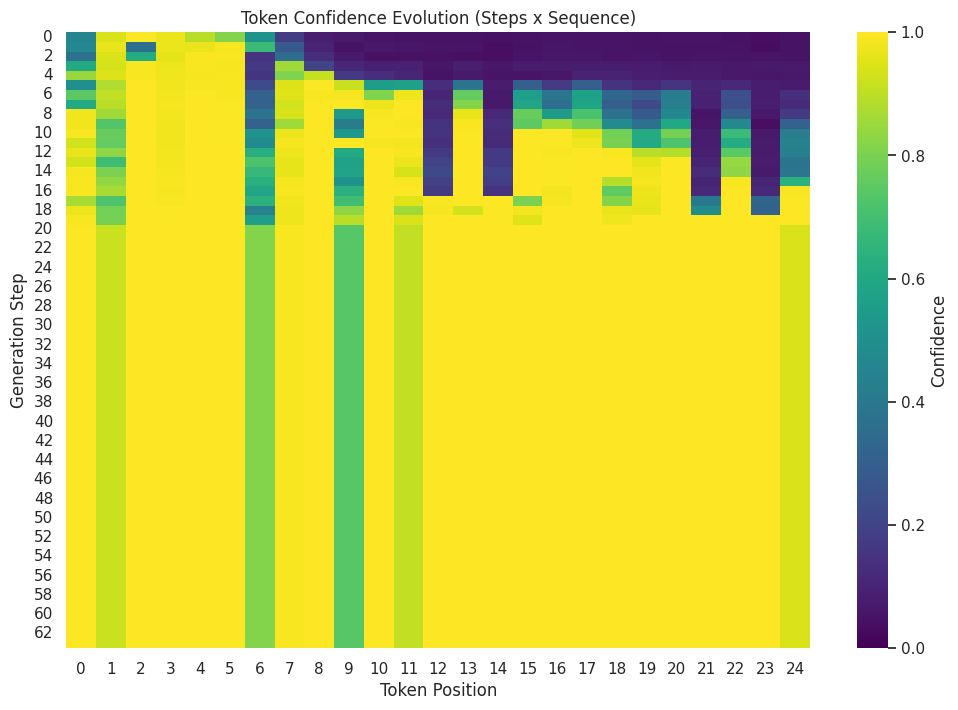

In [7]:
# Deep Inspection 실행
prompt = "The capital of France is"
print(f"Inspecting sampling for prompt: '{prompt}'")

res, details = inspect_sampling(model, tokenizer, prompt, steps=64, gen_length=20)

print("\n[Visualization: Text Evolution]")
visualize_text_evolution(details, tokenizer, show_steps_stride=8)

print("\n[Visualization: Confidence Heatmap]")
plot_confidence_heatmap(details)

## 3. Custom: Your New Algorithm

이곳에 **Backtracking(Remasking)** 등을 포함한 커스텀 알고리즘을 구현하세요.
예시로, **Confidence Threshold**보다 낮은 토큰을 다시 마스킹하는 간단한 로직을 주석으로 포함했습니다.

In [8]:
@torch.no_grad()
def custom_sampling(model, tokenizer, prompt_text, steps=64, gen_length=64, block_length=64, temperature=0.0):
    """
    Custom: Experimental Sampling with Simple Remasking
    """
    mask_id = 126336
    if prompt_text:
        prompt_tokens = tokenizer.encode(prompt_text, return_tensors='pt').to(model.device)
    else:
        prompt_tokens = torch.tensor([[]], dtype=torch.long, device=model.device)

    B, L_prompt = prompt_tokens.shape
    x = torch.full((B, L_prompt + gen_length), mask_id, dtype=torch.long, device=model.device)
    x[:, :L_prompt] = prompt_tokens
    
    num_blocks = gen_length // block_length
    steps = steps // num_blocks
    
    history = []
    start_time = time.time()
    nfe = 0

    # --- [Custom Parameter] ---
    remask_threshold = 0.4  # 이 값보다 confidence가 낮으면 다시 마스킹 시도
    # --------------------------

    for num_block in range(num_blocks):
        block_start = L_prompt + num_block * block_length
        block_end = L_prompt + (num_block + 1) * block_length
        
        # Custom Logic: 여기서는 스텝을 엄격하게 나누지 않고 while 루프나 유동적인 스텝을 사용할 수도 있습니다.
        # 비교를 위해 baseline과 구조를 비슷하게 유지하되, remasking 로직을 추가해봅니다.
        
        for i in range(steps):
            logits = model(x).logits
            nfe += 1
            
            logits_with_noise = add_gumbel_noise(logits, temperature=temperature)
            x0 = torch.argmax(logits_with_noise, dim=-1)
            p = F.softmax(logits.to(torch.float64), dim=-1)
            x0_p = torch.squeeze(torch.gather(p, dim=-1, index=x0.unsqueeze(-1)), -1)
            
            mask_index = (x == mask_id)
            confidence = torch.where(mask_index, x0_p, -np.inf)
            
            # 1. Transfer (Generate)
            # Baseline처럼 k개를 전송하되, 전체 steps 대신 현재 남은 마스크 비율 등을 고려할 수 있습니다.
            current_masks = mask_index.sum().item()
            if current_masks == 0: break
            
            k = max(1, current_masks // (steps - i + 1)) # Simple Linear Schedule
            
            top_values, top_indices = torch.topk(confidence[0], k=k)
            transfer_mask = torch.zeros_like(x, dtype=torch.bool)
            transfer_mask[0, top_indices] = True
            x[transfer_mask] = x0[transfer_mask]
            
            # 2. Remasking (Correction)
            # 이미 생성된 토큰들 중 (프롬프트 제외) confidence가 낮은 것을 다시 마스킹
            generated_mask = (x != mask_id)
            generated_mask[:, :L_prompt] = False # 프롬프트 보호
            
            # 현재 상태의 confidence 확인 (이미 생성된 토큰들의 확률)
            # 주의: 정확한 구현을 위해선 x0_p가 현재 토큰의 확률이어야 함.
            # 위에서 x0는 argmax이므로, 현재 x에 있는 토큰의 확률을 구하려면 gather를 x 기준으로 다시 해야 함.
            current_token_p = torch.squeeze(torch.gather(p, dim=-1, index=x.unsqueeze(-1)), -1)
            
            low_conf_mask = (current_token_p < remask_threshold) & generated_mask
            
            if low_conf_mask.any():
                # 너무 많이 지우면 무한루프 돌 수 있으므로 개수 제한 (예: k의 절반)
                num_remask = min(low_conf_mask.sum().item(), max(1, k // 2))
                # 가장 확신이 없는 것부터 지움
                remask_candidates = torch.where(low_conf_mask, current_token_p, np.inf)
                _, remask_indices = torch.topk(remask_candidates[0], k=num_remask, largest=False)
                
                x[0, remask_indices] = mask_id
            
            history.append({
                'step': i, 'block': num_block, 'nfe': nfe,
                'avg_confidence': current_token_p[generated_mask].mean().item() if generated_mask.any() else 0,
                'text': tokenizer.decode(x[0], skip_special_tokens=True)
            })

    total_time = time.time() - start_time
    return x, history, {'time': total_time, 'nfe': nfe}

## 4. Experiment Runner & Comparison

동일한 프롬프트로 두 알고리즘을 실행하고 지표를 비교합니다.

In [9]:
def run_experiment(prompt, steps=32):
    print(f"Experimenting with prompt: '{prompt}'")
    
    # 1. Run Baseline
    print("Running Baseline...", end=" ")
    res_base, hist_base, stats_base = baseline_sampling(model, tokenizer, prompt, steps=steps)
    print(f"Done. (Time: {stats_base['time']:.2f}s, NFE: {stats_base['nfe']})")
    
    # 2. Run Custom
    print("Running Custom...", end=" ")
    res_cust, hist_cust, stats_cust = custom_sampling(model, tokenizer, prompt, steps=steps)
    print(f"Done. (Time: {stats_cust['time']:.2f}s, NFE: {stats_cust['nfe']})")
    
    # 3. Compare Results
    text_base = tokenizer.decode(res_base[0], skip_special_tokens=True)
    text_cust = tokenizer.decode(res_cust[0], skip_special_tokens=True)
    
    print("\n--- [Outputs] ---")
    print(f"[Baseline]: {text_base}")
    print(f"[Custom]  : {text_cust}")
    
    # 4. Visualization
    # Compare Confidence Evolution
    conf_base = [h['avg_confidence'] for h in hist_base]
    conf_cust = [h['avg_confidence'] for h in hist_cust]
    
    plt.figure(figsize=(14, 5))
    
    # Plot 1: Confidence
    plt.subplot(1, 2, 1)
    plt.plot(conf_base, label=f'Baseline (NFE={stats_base["nfe"]})', marker='o')
    plt.plot(conf_cust, label=f'Custom (NFE={stats_cust["nfe"]})', marker='x')
    plt.title("Average Token Confidence over Steps")
    plt.xlabel("step")
    plt.ylabel("Confidence")
    plt.legend()
    
    # Plot 2: Cost (NFE) vs Time
    plt.subplot(1, 2, 2)
    metrics = ['Time (s)', 'NFE (Cost)']
    x_pos = np.arange(len(metrics))
    w = 0.35
    
    val_base = [stats_base['time'], stats_base['nfe']]
    val_cust = [stats_cust['time'], stats_cust['nfe']]
    
    plt.bar(x_pos - w/2, val_base, w, label='Baseline')
    plt.bar(x_pos + w/2, val_cust, w, label='Custom')
    plt.xticks(x_pos, metrics)
    plt.title("Efficiency Comparison")
    plt.legend()
    
    plt.show()

Experimenting with prompt: 'Python function to merge sort:'
Running Baseline... Done. (Time: 0.69s, NFE: 20)
Running Custom... Done. (Time: 0.69s, NFE: 20)

--- [Outputs] ---
[Baseline]: Python function to merge sort:

```merge(arr,
, low,
, mid,
, high,
  temp)
```

```merge(arr,
  low,
  mid,
  high,
  temp)
```

```merge(arr,
  low,
  mid,
 
[Custom]  : Python function to merge sort:

```python
def merge_sort(arr):
    if len(arr <= 1:
        return arr
    mid = len(arr) //2
    left = merge_sort(arr[:mid]); right = merge_sort(arr[mid:
    =(left


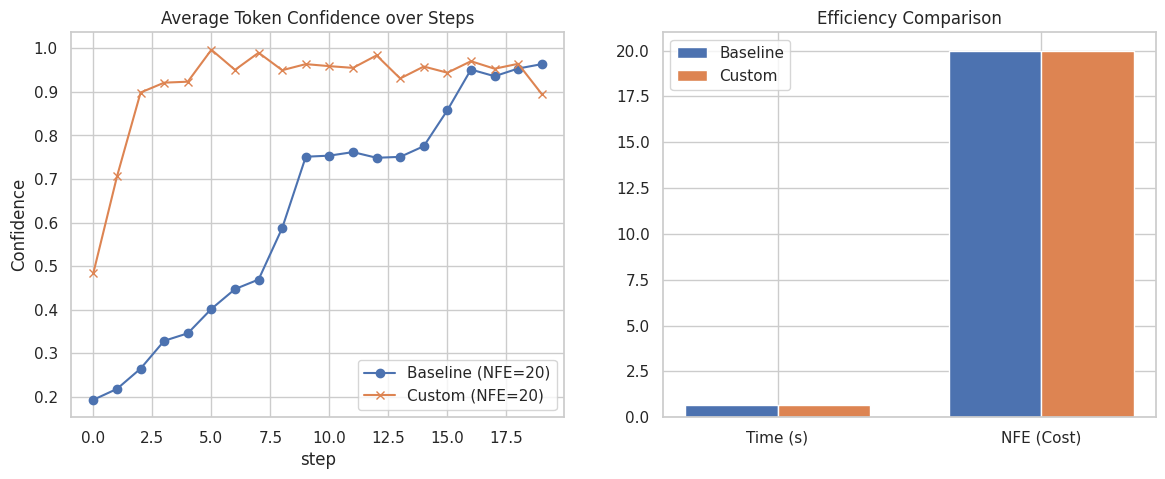

In [10]:
# 실험 실행
# 모델이 로드되어 있어야 합니다.
if 'model' in locals():
    run_experiment("Python function to merge sort:", steps=20)
else:
    print("load model first")